# Development of the IOU functionality 

In [1]:
import sys
import os
project_dir = os.path.dirname(os.getcwd())
sys.path.append(project_dir) #notebooks can't look into source unless you append the parent project directory to the path
print(project_dir)

/home/ubuntu/courtney/usal_echo


In [2]:
def calc_iou(gt, pred):
    gt_bool = np.array(gt, dtype=bool)
    pred_bool = np.array(pred, dtype=bool)
    print('gt_sum:' + str(gt.sum()))
    print('gt_bool :' +str(gt_bool.sum()))
    print('pred_sum:' + str(pred.sum()))
    print('pred_bool :' +str(pred_bool.sum()))

    overlap = gt_bool*pred_bool # Logical AND
    print('Overlap: {}'.format(overlap.sum()))
    union = gt_bool + pred_bool # Logical OR
    print('Union: {}'.format(union.sum()))

    IOU = float(overlap.sum())/float(union.sum())
    
    return IOU

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
from scipy.misc import imresize
import skimage

In [4]:
from src.d00_utils.db_utils import dbReadWriteViews

In [5]:
io_views = dbReadWriteViews()

/home/ubuntu/anaconda3/envs/usal_echo/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [6]:
table = io_views.get_table('frames_by_volume_mask')

In [7]:
file_lookup = io_views.get_table('instances_unique_master_list')
file_lookup.head()

,sopinstanceuid,instancefilename,instanceidk,studyidk
0,1.2.840.113543.6.6.4.6.62554526370968849932129...,6RYXZNZW,57157,2882
1,1.2.840.113543.6.6.4.6.64175920513291079284612...,6RYXZO03,57158,2882
2,1.2.840.113543.6.6.4.6.63515355813678132433121...,6RYXZO0D,57159,2882
3,1.2.840.113543.6.6.4.6.63385835434171778347132...,6RYXZO0K,57160,2882
4,1.2.840.113543.6.6.4.6.62250778798156715321013...,6RYXZO0Y,57161,2882


In [8]:
table_filenames = pd.merge(table, file_lookup, how='left', on =['instanceidk', 'studyidk'])
table_filenames.head()

,instanceidk,indexinmglist,studyidk,frame,view_name,view_exists,view_only,ventricle_only,cycle_only,sopinstanceuid,instancefilename
0,57164,0,2882,8,a4c_ven_ed,False,a4c,ven,ed,1.2.840.113543.6.6.4.6.61287632529377935401711...,6RYXZO20
1,57164,1,2882,15,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113543.6.6.4.6.61287632529377935401711...,6RYXZO20
2,58207,0,2966,1,a4c_ven_ed,False,a4c,ven,ed,1.2.840.113543.6.6.4.6.62432989118278372356313...,7QVURND6
3,58207,1,2966,8,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113543.6.6.4.6.62432989118278372356313...,7QVURND6
4,102950,0,5898,17,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113543.6.6.4.6.61767879315804788584108...,FN8YYXBS


In [9]:
instance_id_list = io_views.get_table('instances_with_labels_scrappy100') #this is the list of 100 study ids from Dave
instance_id_list = instance_id_list.instanceidk
print(instance_id_list.shape)

print('check orginal number of instances in table with filenames')
print(table_filenames.instanceidk.nunique())

(100,)
check orginal number of instances in table with filenames
33639


In [10]:
#Filter the table_filenames table to only include these 100 studies
table_filenames_filtered_100 = table_filenames[table_filenames['instanceidk'].isin(instance_id_list)]

In [11]:
table_filenames_filtered_100 = table_filenames_filtered_100[table_filenames_filtered_100.view_exists == True]

In [12]:
table_filenames_filtered_100 = table_filenames_filtered_100.reset_index()

In [13]:
print(table_filenames_filtered_100.instanceidk.nunique())
print(table_filenames_filtered_100.shape)
table_filenames_filtered_100.head()

37
(87, 12)


,index,instanceidk,indexinmglist,studyidk,frame,view_name,view_exists,view_only,ventricle_only,cycle_only,sopinstanceuid,instancefilename
0,5616,1240503,0,63712,37,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.365900332.3.55.20150326....,45TXWHPP ...
1,15923,1533277,0,75772,45,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406799603.3.17.20160129....,1NC37590 ...
2,16619,1547148,0,76235,50,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406857159.3.13.20160209....,2O353AET ...
3,21542,1638471,0,79213,54,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406799603.3.14.20160408....,57I8CI1G ...
4,21913,1648911,0,79559,32,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406857159.3.18.20160413....,59SXP37K ...


In [14]:
print(table_filenames_filtered_100.shape)
table_filenames_filtered_100.view_name.value_counts()

(87, 12)


a4c_ven_ed    22
a4c_ven_es    21
a4c_atr_es    13
a2c_atr_es    12
a2c_ven_ed    10
a2c_ven_es     9
Name: view_name, dtype: int64

In [15]:
table_filenames_filtered_100['instanceidk'].count()

87

In [16]:
table_filenames_filtered_100.to_csv('pre_predict_100_filenames.txt', header=True)

ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a4c/a_63712_45TXWHPP.dcm_lv.npy
orginal pred shape: (70, 384, 384)
orginal pred sum: 105119
frame: 37
pred_frame shape: (384, 384)
gt_sum:5188
gt_bool :5188
pred_sum:0
pred_bool :0
Overlap: 0
Union: 5188
IOU score added: 0.0


/home/ubuntu/anaconda3/envs/usal_echo/lib/python3.6/site-packages/ipykernel/__main__.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a4c/a_75772_1NC37590.dcm_lv.npy
orginal pred shape: (93, 384, 384)
orginal pred sum: 255360
frame: 45
pred_frame shape: (384, 384)
gt_sum:9792
gt_bool :9792
pred_sum:0
pred_bool :0
Overlap: 0
Union: 9792
IOU score added: 0.0
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a4c/a_76235_2O353AET.dcm_lv.npy
orginal pred shape: (79, 384, 384)
orginal pred sum: 400860
frame: 50
pred_frame shape: (384, 384)
gt_sum:5237
gt_bool :5237
pred_sum:4847
pred_bool :4847
Overlap: 3980
Union: 6104
IOU score added: 0.6520314547837484
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a4c/a_79213_57I8CI1G.dcm_lv.npy
orginal pred shape: (111, 384, 384)
orginal pred sum: 228569
frame: 54
pred_frame shape: (384, 384)
gt_sum:6862
gt_bool :6862
pred_sum:0
pred_bool :0
Overlap: 0
Union: 6862
IOU score added: 0.0
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segm

/home/ubuntu/anaconda3/envs/usal_echo/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


orginal pred shape: (70, 384, 384)
orginal pred sum: 105119
frame: 55
pred_frame shape: (384, 384)
gt_sum:3381
gt_bool :3381
pred_sum:0
pred_bool :0
Overlap: 0
Union: 3381
IOU score added: 0.0
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a4c/a_63712_45TXWHPP.dcm_lv.npy
orginal pred shape: (70, 384, 384)
orginal pred sum: 105119
frame: 52
pred_frame shape: (384, 384)
gt_sum:3287
gt_bool :3287
pred_sum:0
pred_bool :0
Overlap: 0
Union: 3287
IOU score added: 0.0
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a4c/a_75772_1NC37590.dcm_lv.npy
orginal pred shape: (93, 384, 384)
orginal pred sum: 255360
frame: 62
pred_frame shape: (384, 384)
gt_sum:4456
gt_bool :4456
pred_sum:0
pred_bool :0
Overlap: 0
Union: 4456
IOU score added: 0.0
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a4c/a_76235_2O353AET.dcm_lv.npy
orginal pred shape: (79, 384, 384)
orginal pred sum: 400860
frame: 62
pred_frame shape: (384, 384

orginal pred sum: 693919
frame: 53
pred_frame shape: (384, 384)
gt_sum:8133
gt_bool :8133
pred_sum:7613
pred_bool :7613
Overlap: 7342
Union: 8404
IOU score added: 0.8736316039980961
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a2c/a_74813_1F2EH2I9.dcm_lv.npy
orginal pred shape: (82, 384, 384)
orginal pred sum: 406564
frame: 56
pred_frame shape: (384, 384)
gt_sum:1971
gt_bool :1971
pred_sum:5256
pred_bool :5256
Overlap: 1971
Union: 5256
IOU score added: 0.375
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a2c/a_76915_2U24W10O.dcm_lv.npy
orginal pred shape: (101, 384, 384)
orginal pred sum: 179005
frame: 74
pred_frame shape: (384, 384)
gt_sum:2999
gt_bool :2999
pred_sum:0
pred_bool :0
Overlap: 0
Union: 2999
IOU score added: 0.0
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a2c/a_86564_ALTVTC6C.dcm_lv.npy
orginal pred shape: (97, 384, 384)
orginal pred sum: 195229
frame: 65
pred_frame shape: (384, 38

gt_bool :5106
pred_sum:5938
pred_bool :5938
Overlap: 5067
Union: 5977
IOU score added: 0.8477497072109754
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a2c/a_105241_BN1N2RGV.dcm_la.npy
orginal pred shape: (90, 384, 384)
orginal pred sum: 225830
frame: 41
pred_frame shape: (384, 384)
gt_sum:4699
gt_bool :4699
pred_sum:3845
pred_bool :3845
Overlap: 3723
Union: 4821
IOU score added: 0.7722464219041693
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a2c/a_106819_CYTLZWUI.dcm_la.npy
orginal pred shape: (122, 384, 384)
orginal pred sum: 202373
frame: 86
pred_frame shape: (384, 384)
gt_sum:5404
gt_bool :5404
pred_sum:0
pred_bool :0
Overlap: 0
Union: 5404
IOU score added: 0.0
ground truth shape: (384, 384)
/home/ubuntu/courtney/usal_echo/data/segment/a2c/a_108968_EDTCNAUE.dcm_la.npy
orginal pred shape: (83, 384, 384)
orginal pred sum: 355853
frame: 62
pred_frame shape: (384, 384)
gt_sum:4806
gt_bool :4806
pred_sum:4453
pred_bool :4453
O

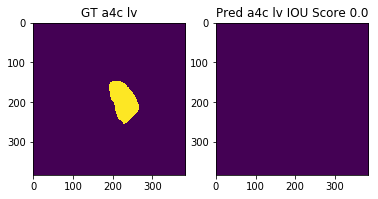

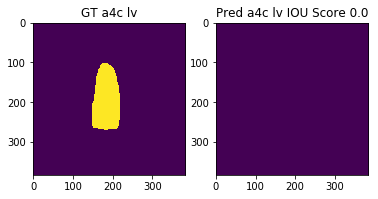

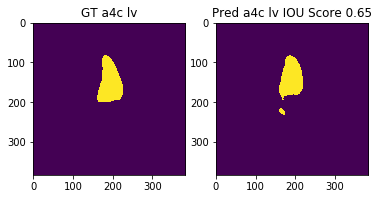

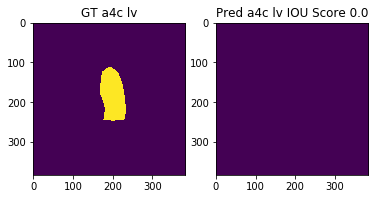

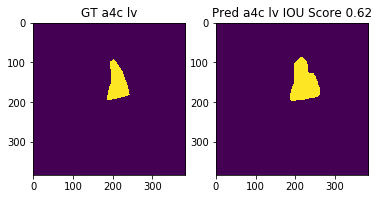

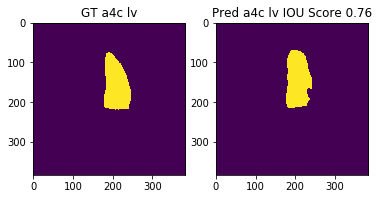

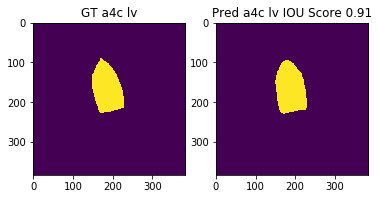

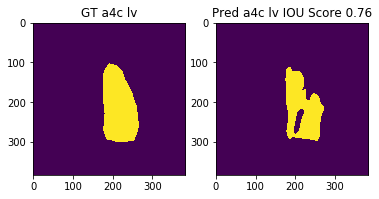

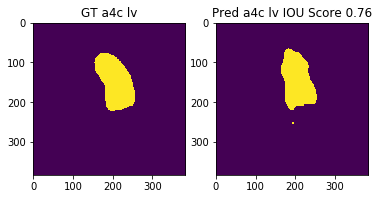

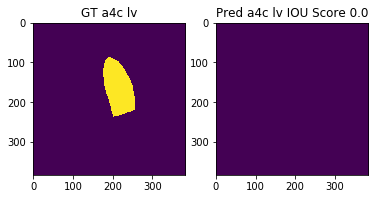

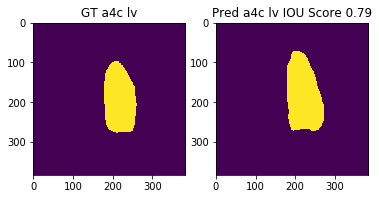

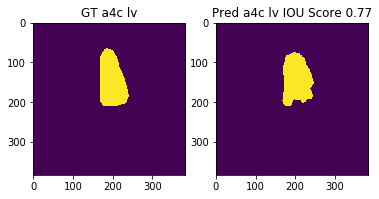

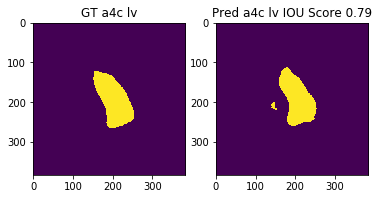

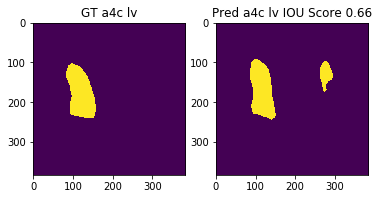

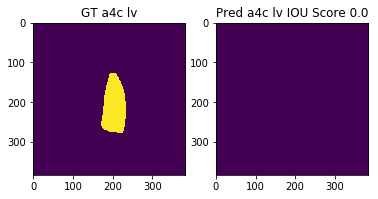

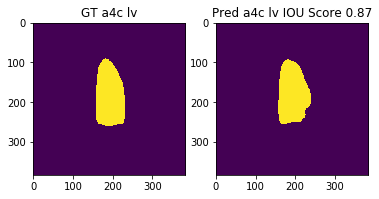

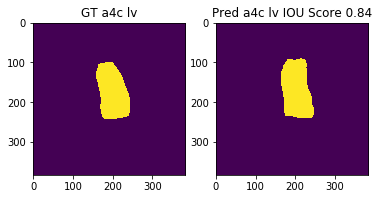

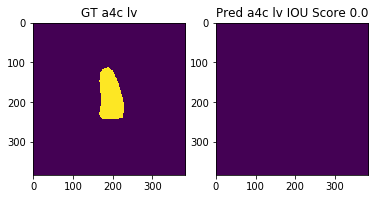

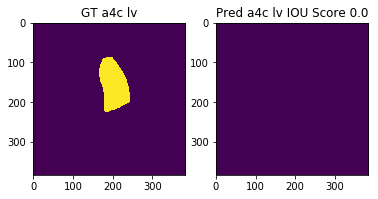

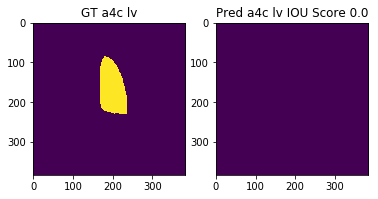

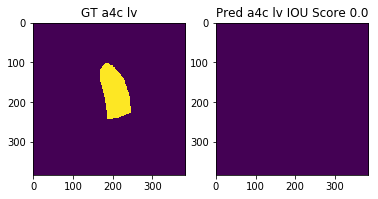

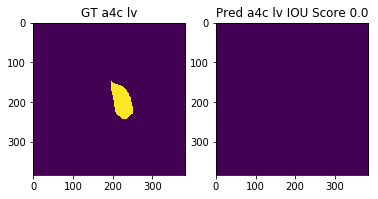

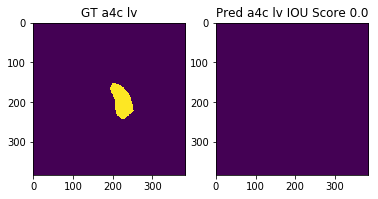

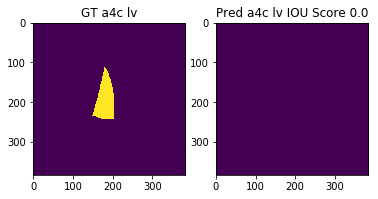

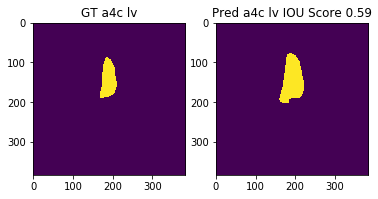

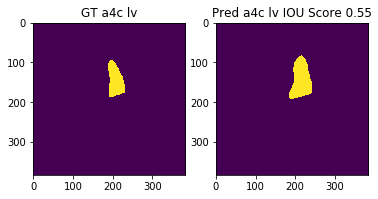

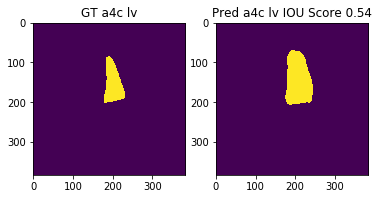

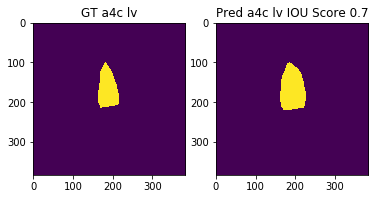

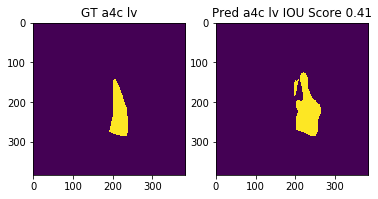

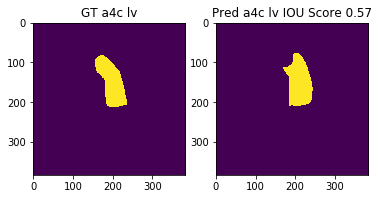

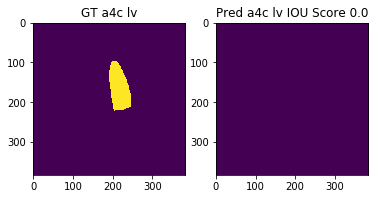

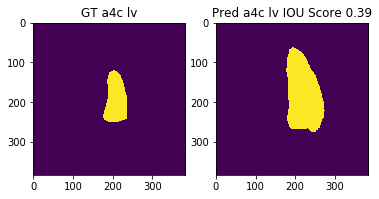

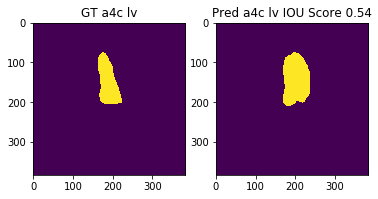

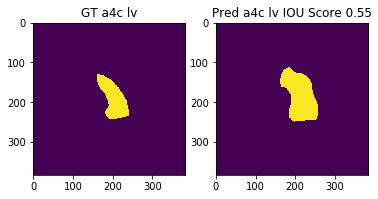

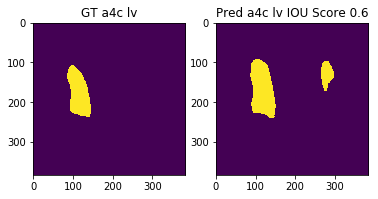

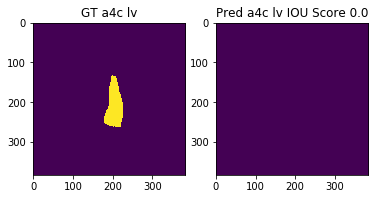

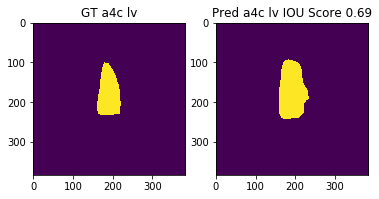

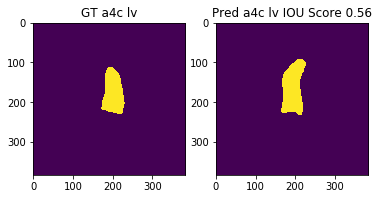

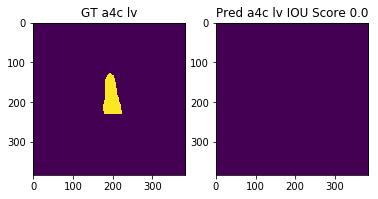

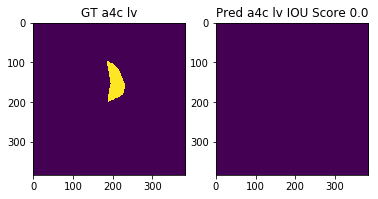

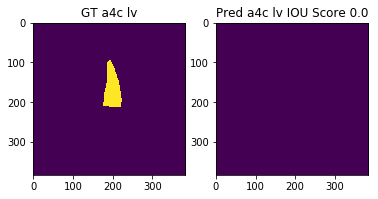

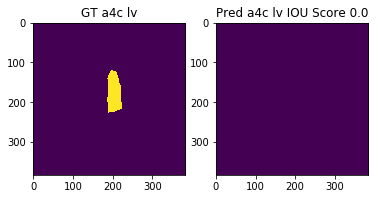

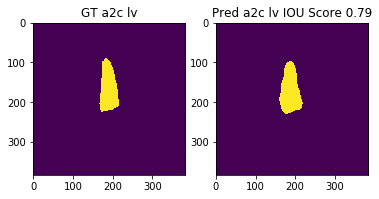

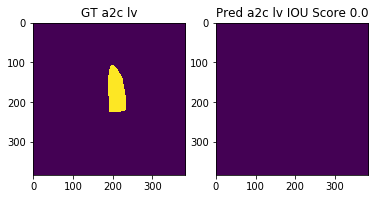

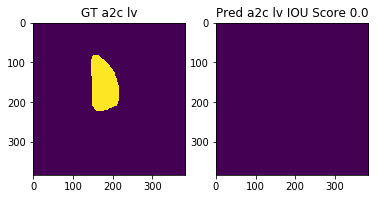

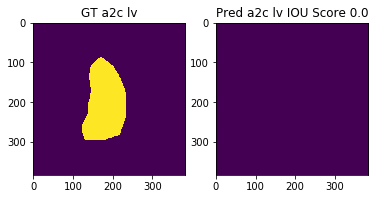

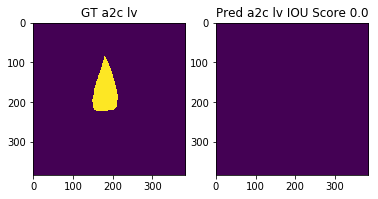

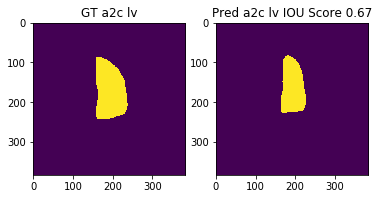

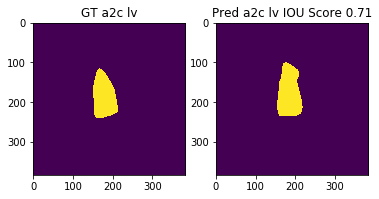

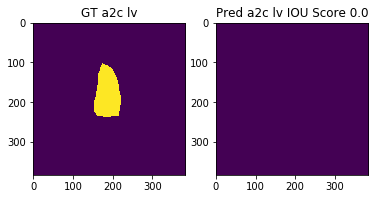

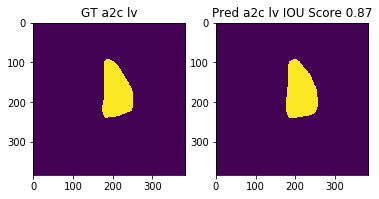

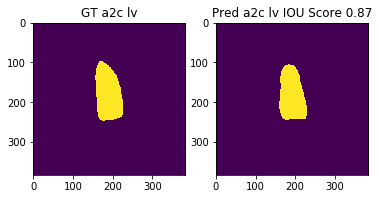

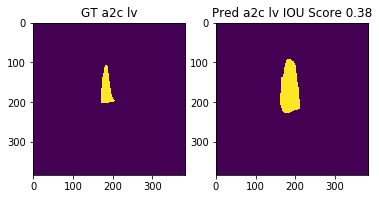

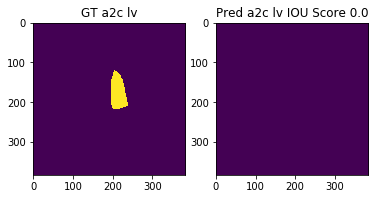

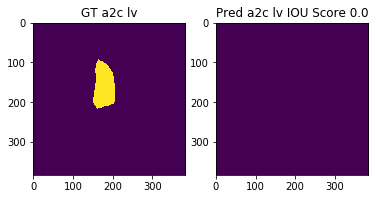

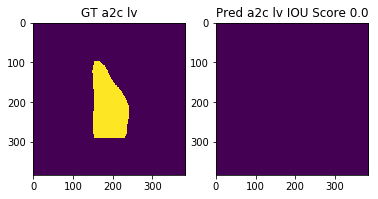

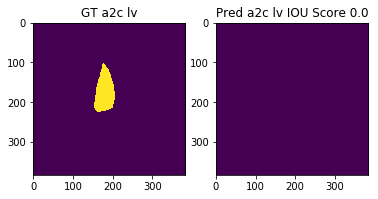

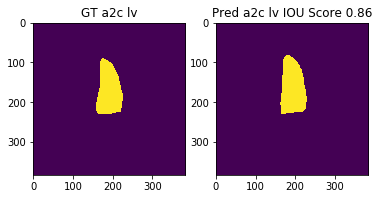

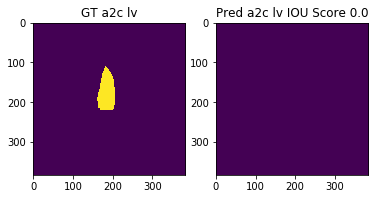

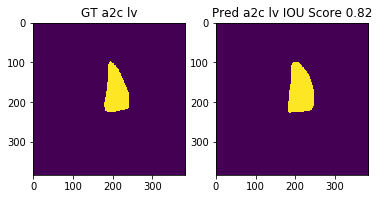

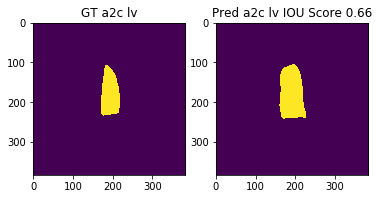

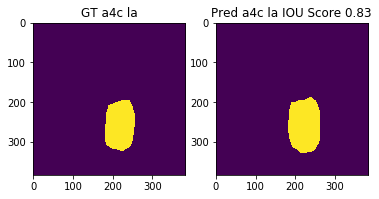

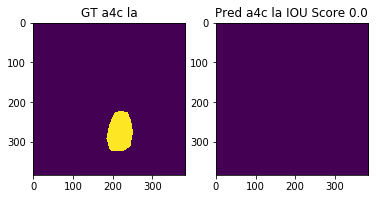

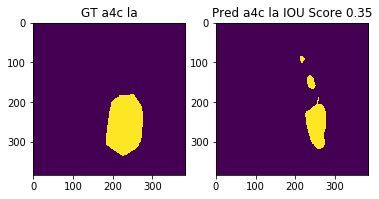

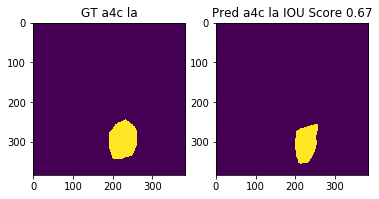

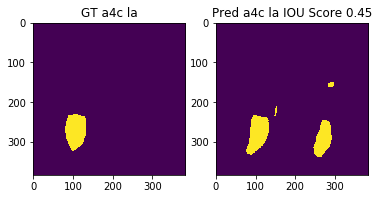

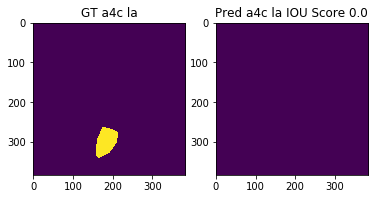

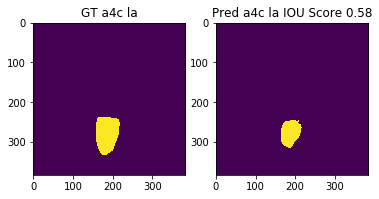

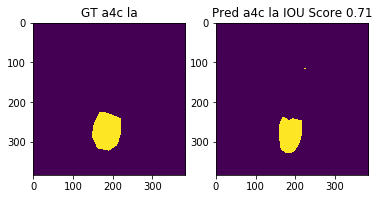

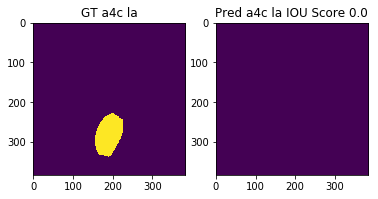

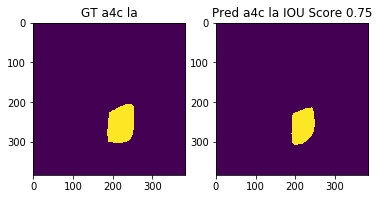

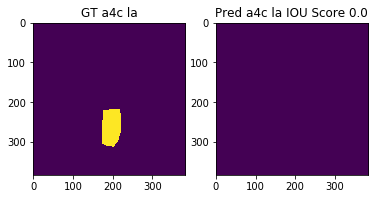

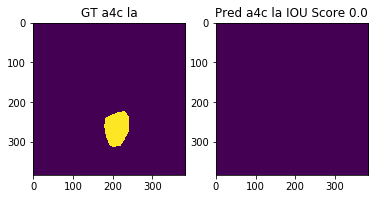

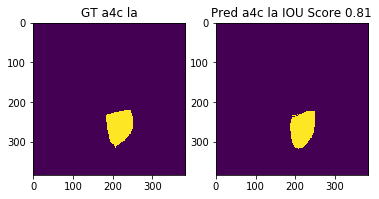

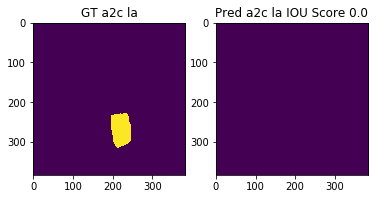

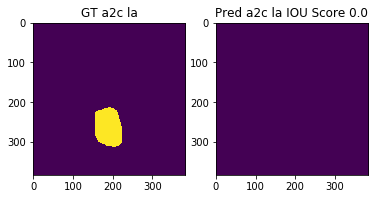

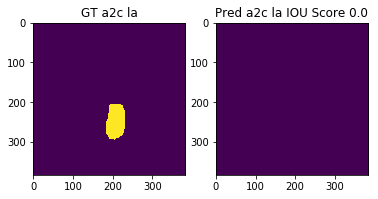

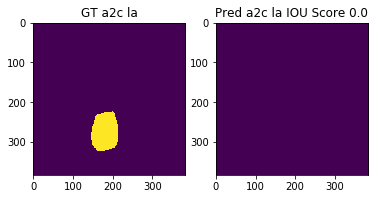

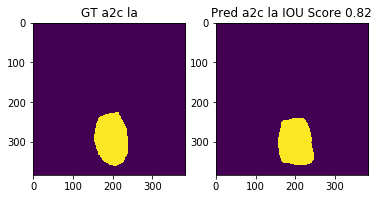

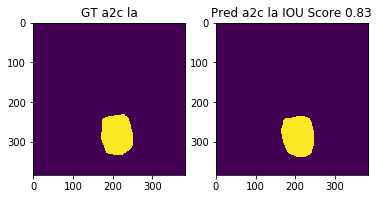

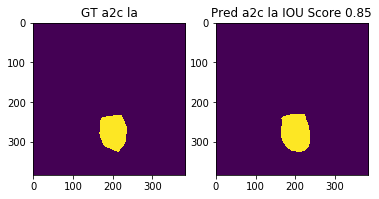

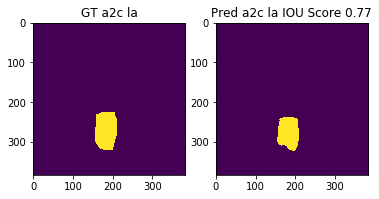

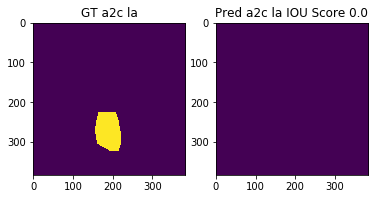

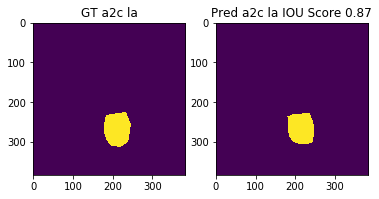

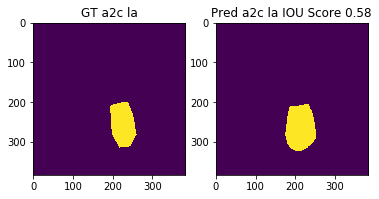

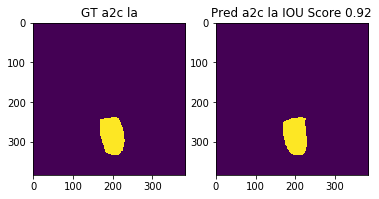

In [17]:
# go through each of the views and select the:
# gt file (think about convention)
# match to pred file frame chamber

table_filenames_filtered_100['iou_score'] = ''

for i in table_filenames_filtered_100.index:
    #ground truth
    fileno = str(table_filenames_filtered_100.at[i, 'instancefilename'])
    frame = table_filenames_filtered_100.at[i, 'frame']
    view = table_filenames_filtered_100.at[i, 'view_only']
    chamber = table_filenames_filtered_100.at[i, 'ventricle_only']
    instance = table_filenames_filtered_100.at[i, 'instanceidk']
    study = table_filenames_filtered_100.at[i, 'studyidk']
       
    #convert chamber to the right format
    if chamber == 'ven':
        chamber = 'lv'
    if chamber == 'atr':
        chamber = 'la'
        
    gt_filename = str('a_' + str(fileno).strip() + '.dcm_'+ str(frame).strip() + '_' + chamber + '_gt.npy')
    gt_path = str('/home/ubuntu/courtney/usal_echo/data/segment/gt_masks/{}'.format(gt_filename))
    
    gt = np.load(gt_path)
    gt = imresize(gt, (384,384))
    print('ground truth shape: {}'.format(gt.shape))
    
    #find corresponding prediction
    pred_filename = str('a_' + str(study).strip() + '_' + str(fileno).strip() + '.dcm_' + chamber + '.npy')
    pred_path = str('/home/ubuntu/courtney/usal_echo/data/segment/{}/{}'.format(view, pred_filename))
    print(pred_path)

    try:
        pred = np.load(pred_path)
        print('orginal pred shape: {}'.format(pred.shape))
        print('orginal pred sum: {}'.format(pred.sum()))
        print('frame: {}'.format(frame))
        pred_frame = pred[frame,:,:] # selecting only the frame with the relevant gt
        print('pred_frame shape: {}'.format(pred_frame.shape))
        score = calc_iou(gt, pred_frame)
        table_filenames_filtered_100.at[i, 'iou_score'] = score
        print('IOU score added: {}'.format(score))
        
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(gt)
        plt.title('GT {} {}'.format(view, chamber))
        plt.subplot(1, 2, 2)
        plt.imshow(pred_frame)
        plt.title('Pred {} {} IOU Score {}'.format(view, chamber, round(score,2)))
    except:
        print("Oops!",sys.exc_info()[0],"occured.  File {} doesn't exist".format(pred_path))
        print()

In [18]:
table_filenames_filtered_100.iou_score = table_filenames_filtered_100.iou_score.replace('', np.nan)

print("Number of files tested: {}".format(table_filenames_filtered_100.instanceidk.count()))
print("Number of files found: {}" .format(table_filenames_filtered_100.iou_score.count()))
print("Average IOU: {}".format(round(table_filenames_filtered_100.iou_score.mean(), 2)))

Number of files tested: 87
Number of files found: 86
Average IOU: 0.39


In [19]:
table_filenames_filtered_100

,index,instanceidk,indexinmglist,studyidk,frame,view_name,view_exists,view_only,ventricle_only,cycle_only,sopinstanceuid,instancefilename,iou_score
0,5616,1240503,0,63712,37,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.365900332.3.55.20150326....,45TXWHPP ...,0.000000
1,15923,1533277,0,75772,45,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406799603.3.17.20160129....,1NC37590 ...,0.000000
2,16619,1547148,0,76235,50,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406857159.3.13.20160209....,2O353AET ...,0.652031
3,21542,1638471,0,79213,54,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406799603.3.14.20160408....,57I8CI1G ...,0.000000
4,21913,1648911,0,79559,32,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406857159.3.18.20160413....,59SXP37K ...,0.616530
5,25328,1727852,0,82123,35,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406830382.3.9.20160531.1...,6S0FOEVT ...,0.757362
6,25769,1737512,0,82418,1,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406799603.3.13.20160606....,7QGSK815 ...,0.909481
7,26748,1761457,0,83180,0,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406857159.3.57.20160620....,7WWBQZMB ...,0.759464
8,26768,1761658,0,83188,4,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.406857159.3.12.20160620....,7WWBSGXD ...,0.761570
9,30654,1843953,0,85827,45,a4c_ven_ed,True,a4c,ven,ed,1.2.840.113663.1500.1.402357036.3.20.20160812....,AD3NIUKH ...,0.000000


In [20]:
## for now, write out a csv with results
#project_dir = os.path.dirname(os.getcwd())
#data_dir = os.path.join(project_dir, "notebooks", "seg_testing")

#if not os.path.exists(data_dir):
#    os.makedirs(data_dir)

#time_stamp = datetime.date.today()
#file_name = 'scappy_100_w_mdl_probs_test' + str(time_stamp) + '.txt'
#data_path = os.path.join(data_dir, file_name)

#table_filenames_filtered_100.to_csv (data_path, index = None, header=True) 

In [21]:
table_filenames_filtered_100.to_csv('20190805_pm_predictions_gt.csv')